CREDITWORTHINESS FOR A CREDIT CARD ISSUANCE

Let's start importing all necessary libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

Then merge the two csv files based on the IDs they have in common

In [2]:
application_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

merged_df = application_df.merge(credit_df, on='ID', how='inner')
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


DATA PRE-PROCESSING

Let's start checking for null values presence

In [3]:
merged_df.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

We note that more than one-third of the OCCUPATION_TYPE column contains null values, so we drop the column and also take the opportunity to drop FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, which indicate the presence of a telephone and email address, personal or work, information that brings no added value to our survey. We also eliminate the CODE_GENDER column; it is unlikely that a credit card would not be granted for one's gender.

In [4]:
merged_df = merged_df.drop(['CODE_GENDER','OCCUPATION_TYPE','FLAG_MOBIL',
                            'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'],
                           axis=1)

Let's look at some data on our dataset

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
merged_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,777715.00,777715.00,777715.00,777715.00,777715.00,777715.00,777715.00
mean,5078742.95,0.43,188534.80,-16124.94,57775.83,2.21,-19.37
std,41804.42,0.75,101622.45,4104.30,136471.74,0.91,14.08
min,5008804.00,0.00,27000.00,-25152.00,-15713.00,1.00,-60.00
25%,5044568.50,0.00,121500.00,-19453.00,-3292.00,2.00,-29.00
50%,5069530.00,0.00,162000.00,-15760.00,-1682.00,2.00,-17.00
75%,5115551.00,1.00,225000.00,-12716.00,-431.00,3.00,-8.00
max,5150487.00,19.00,1575000.00,-7489.00,365243.00,20.00,0.00


We note two outliers, 19 for the CNT_CHILDREN feature and 365243 for DAYS_EMPLOYED, an impossible figure given that it is equivalent to more than a thousand years. To begin with, let us see how our CNT_CHILDREN column is made.

In [6]:
merged_df['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: count, dtype: int64

We note that families with more than five children are a minority, so we will proceed to delete them by keeping only those with five or fewer children.

In [7]:
merged_df = merged_df.loc[merged_df['CNT_CHILDREN'] <= 5]

We also delete all rows containing the value 365243 for DAYS_EMPLOYED.

In [8]:
merged_df = merged_df.drop(merged_df[merged_df['DAYS_EMPLOYED'] == 365243].index)

Let us now check whether after these operations we have values in the normal range

In [9]:
merged_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,649580.00,649580.00,649580.00,649580.00,649580.00,649580.00,649580.00
mean,5079218.34,0.50,196675.36,-15007.97,-2782.53,2.30,-19.34
std,41808.71,0.76,104120.83,3444.13,2419.19,0.92,14.06
min,5008804.00,0.00,27000.00,-24611.00,-15713.00,1.00,-60.00
25%,5045227.00,0.00,135000.00,-17644.00,-3680.00,2.00,-29.00
50%,5078990.00,0.00,180000.00,-14775.00,-2174.00,2.00,-17.00
75%,5115668.00,1.00,225000.00,-12196.00,-1050.00,3.00,-8.00
max,5150487.00,5.00,1575000.00,-7489.00,-17.00,7.00,0.00


It would appear so. We only notice a very high value for the AMT_INCOME_TOTAL feature, which we decide to keep, however. Let us create a copy of the dataset; it will become clear to us later why.

In [10]:
df = merged_df.copy()

ENCODING OF VARIABLES.

We create mapping functions to encode: FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_EDUCATION_TYPE.

In [11]:
flag_mapping = {"N":0, "Y":1}
education_mapping = {"Lower secondary":1, "Secondary / secondary special":2,
                     "Higher education":3, "Incomplete higher":4,
                     "Lower secondary":5, "Academic degree":6}
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map(flag_mapping)
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].map(flag_mapping)
df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].map(education_mapping)

Now let's create dummies variables for categorical nonbinary features.

In [12]:
df = pd.get_dummies(df, columns=["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS",
                                               "NAME_HOUSING_TYPE"])
df.replace({True:1, False:0}, inplace=True)

ENCODING OF THE TARGET VARIABLE

We will use STATUS as the target, but to do so we must first encode it in binary. We then create a function that taken each ID checks the value of STATUS for each value of MONTHS_BALANCE, if the client in its history has a majority of C or 0 it will be considered reliable and will have value 1, otherwise it will have value 0.

In [13]:
def encode_status(df, threshold=0.5):

    threshold_count = threshold * df['MONTHS_BALANCE'].nunique()
    status_counts = df.groupby('ID')['STATUS'].apply(lambda x: (x == 'C').sum() +
                                                           (x == '0').sum())
    reliable_clients = status_counts > threshold_count
    status_mapping = {True: 1, False: 0}
    df['STATUS'] = df['ID'].map(reliable_clients).map(status_mapping)
    return df

We perform STATUS coding and delete MONTHS_BALANCE and ID since we no longer need them. Finally, we check the values obtained

In [14]:
df = encode_status(df)
df = df.drop(['MONTHS_BALANCE','ID'], axis=1)

In [15]:
df["STATUS"].value_counts()

STATUS
0    397608
1    251972
Name: count, dtype: int64

We notice that the negative class is more present than the positive class, let's keep this in mind for when we go to train our models

MODEL CREATION AND TRAINING

LOGISTIC REGRESSION

We begin by creating a simple logistic regression model that we will use as a benchmark. We create a copy of our dataset and go to run a train test split, we will use 20% of the dataset as the test set, also with the stratify parameter we ensure that the data maintain the same proportion on both sets.

In [16]:
lr_balanced_df = df.copy()
X = lr_balanced_df.drop("STATUS", axis=1).values
y = lr_balanced_df["STATUS"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

Then standardize our data

In [17]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Then we create the model and perform the fit on X_train and y_train, since we are dealing with unbalanced classes we will use the parameter class_weight='balanced'

In [18]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Now let's calculate probabilities:

In [19]:
y_proba_train = lr.predict_proba(X_train)
y_proba_test = lr.predict_proba(X_test)

And making our predictions:

In [20]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

Let's print a classification_report for each dataset:

In [21]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58    318086
           1       0.42      0.53      0.47    201578

    accuracy                           0.53    519664
   macro avg       0.53      0.53      0.52    519664
weighted avg       0.55      0.53      0.54    519664



In [22]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58     79522
           1       0.42      0.53      0.46     50394

    accuracy                           0.53    129916
   macro avg       0.53      0.53      0.52    129916
weighted avg       0.55      0.53      0.53    129916



We notice suboptimal values, our model is not complex enough to fully capture the relationships among our data, the ROC Curve will confirm this

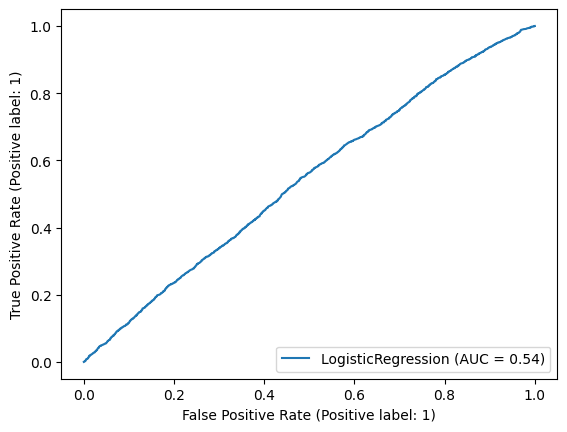

In [23]:
RocCurveDisplay.from_estimator(lr,X_train,y_train)

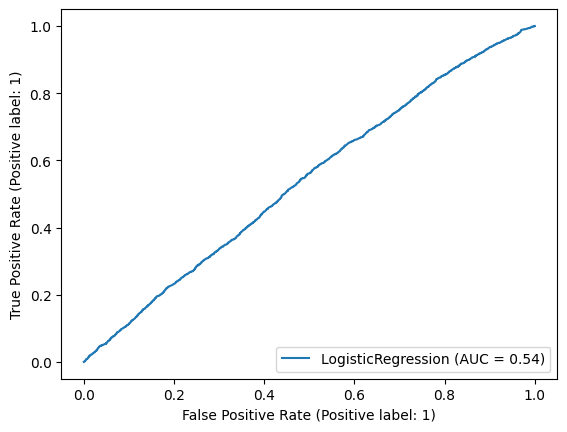

In [24]:
RocCurveDisplay.from_estimator(lr,X_test,y_test)

With an AUC of 0.54 for both sets we have confirmation that we need a more complex model

XGBOST

This algorithm, based on decision trees, uses a boosting method, iteratively training a set of weak decision trees, optimizing the objective function by gradient descent. It also manages overfitting well, a problem we may run into given our unbalanced classes.

As always we create a copy of our dataset, later we go on to create X_train, X_test, y_train, y_test and standardize our data.

In [25]:
xgb_df = df.copy()

X = xgb_df.drop("STATUS", axis=1).values
y = xgb_df["STATUS"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Let us now initialize our model, to best address the problem of unbalanced classes let us calculate scale_pos_weight, which is the ratio of the number of samples in the negative class to the number of samples in the positive class. This parameter is used during model training to assign more weight to instances in the positive class than to those in the negative class.

Finally, we perform the fit on our data:

In [26]:
pos_class = sum(y == 1)
neg_class = sum(y == 0)
scale_pos_weight = neg_class / pos_class

xgb_m = xgb.XGBClassifier(
    scale_pos_weight = scale_pos_weight, objective='binary:logistic', eval_metric="auc")

xgb_m.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Let's calculate probabilities and predictions for both sets:

In [27]:
y_proba_train = xgb_m.predict_proba(X_train)
y_proba_test = xgb_m.predict_proba(X_test)

In [28]:
y_pred_train = xgb_m.predict(X_train)
y_pred_test = xgb_m.predict(X_test)

Let's print classification_reports

In [29]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78    318086
           1       0.65      0.80      0.72    201578

    accuracy                           0.75    519664
   macro avg       0.75      0.76      0.75    519664
weighted avg       0.77      0.75      0.76    519664



In [30]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78     79522
           1       0.64      0.80      0.71     50394

    accuracy                           0.75    129916
   macro avg       0.75      0.76      0.75    129916
weighted avg       0.77      0.75      0.75    129916



We get more encouraging results even though the positive class continues to suffer. Let's see what the ROC Curves tell us.

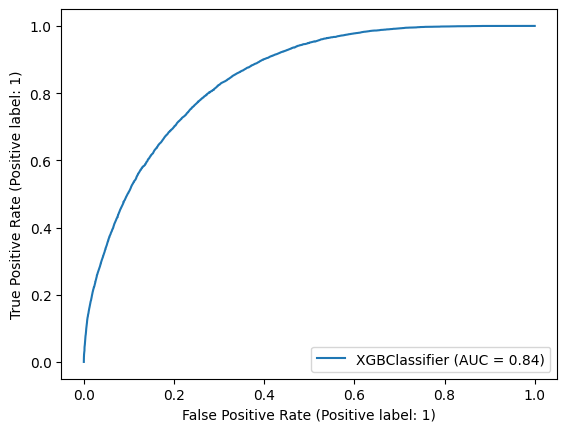

In [31]:
RocCurveDisplay.from_estimator(xgb_m,X_train,y_train)

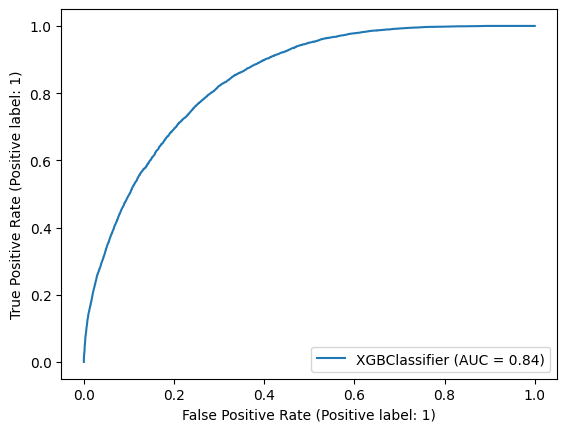

In [32]:
RocCurveDisplay.from_estimator(xgb_m,X_test,y_test)

Compared with logistic regression, the situation is definitely improved from a 0.53 to a 0.85 for the train set, and 0.85 for the test set. However, let see if we can do better with another algorithm based on decision trees, Random Forest.

RANDOM FOREST CLASSIFIER

This algorithm is based on a set of decision trees. Each tree is trained on a random subset of the features and the predictions are combined by voting or averaging, this makes the model handle overfitting well and generalize to new data.
Again we make a copy of our dataset and create our X_train,X_test, y_train, y_test, this time however we don't standardize, there is no need with random forest.

In [33]:
rfc_df = df.copy()

X = rfc_df.drop("STATUS", axis=1).values
y = rfc_df["STATUS"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)


Let's initialize our model and execute the fit. Again we use balanced since we have unbalanced classes and n_jobs = -1 to parallelize the processes and execute the job faster.

In [34]:
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

Let's calculate probabilities and our predictions.

In [35]:
y_proba_train = rfc.predict_proba(X_train)
y_proba_test = rfc.predict_proba(X_test)

y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

Then we print our classification_reports 

In [36]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.75      0.83    318086
           1       0.70      0.89      0.78    201578

    accuracy                           0.81    519664
   macro avg       0.80      0.82      0.80    519664
weighted avg       0.83      0.81      0.81    519664



In [37]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82     79522
           1       0.69      0.88      0.78     50394

    accuracy                           0.80    129916
   macro avg       0.80      0.82      0.80    129916
weighted avg       0.83      0.80      0.80    129916



We can be satisfied, in fact we got very good metrics on both sets, we were able to increase precision and recall for both classes. Let's take a look at the ROC Curves

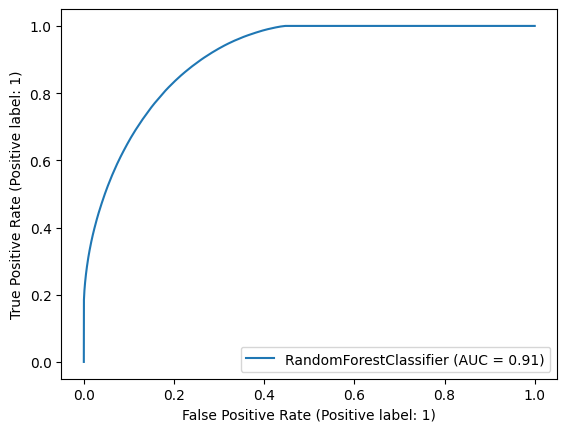

In [38]:
RocCurveDisplay.from_estimator(rfc,X_train,y_train)

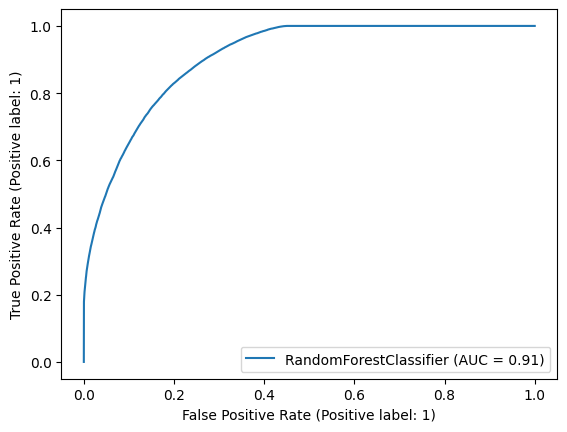

In [39]:
RocCurveDisplay.from_estimator(rfc,X_test,y_test)

We had a marked improvement, going from 0.84 in XGBoost to a very good 0.91 on both sets.

LET'S SIMPLIFY OUR DATASET

We are dealing with a very complex dataset, let's see if we can simplify it without altering the results.

In [40]:
df.shape

(649580, 25)

In [41]:
pd.options.display.max_columns = None
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,STATUS,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,1,1,0,427500.00,3,-12005,-4542,2.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,1,1,0,427500.00,3,-12005,-4542,2.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,1,1,0,427500.00,3,-12005,-4542,2.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3,1,1,0,427500.00,3,-12005,-4542,2.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,1,0,427500.00,3,-12005,-4542,2.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0


We see that it consists of 25 columns, most given by the different dummy variables. We then begin by recopying our dataset by eliminating features that lead us to have different columns for each dummy variable, specifically: NAME_EDUCATION_TYPE, NAME_INCOME_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, OCCUPATION_TYPE

In [42]:
df = merged_df.drop(['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS',
                     'NAME_HOUSING_TYPE'], axis=1)

We continue as done previously with encoding features FLAG_OWN_CAR, FLAG_OWN_REALTY and encoding STATUS through our function, and then finally dropping MONTHS_BALANCE and ID

In [43]:
flag_mapping = {"N":0, "Y":1}
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map(flag_mapping)
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].map(flag_mapping)

df = encode_status(df)
df = df.drop(['MONTHS_BALANCE','ID'], axis=1)

We check that everything is in order

In [44]:
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,1,1,0,427500.00,-12005,-4542,2.00,0
1,1,1,0,427500.00,-12005,-4542,2.00,0
2,1,1,0,427500.00,-12005,-4542,2.00,0
3,1,1,0,427500.00,-12005,-4542,2.00,0
4,1,1,0,427500.00,-12005,-4542,2.00,0


RANDOM FOREST CLASSIFIER WITH SIMPLIFIED DATASET

Now let's train the model on our new dataset and see if there are any changes

In [45]:
X = df.drop("STATUS", axis=1).values
y = df["STATUS"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [46]:
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [47]:
y_proba_train = rfc.predict_proba(X_train)
y_proba_test = rfc.predict_proba(X_test)

y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

CLASSIFICATION REPORT

In [48]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82    318086
           1       0.69      0.89      0.78    201578

    accuracy                           0.80    519664
   macro avg       0.80      0.82      0.80    519664
weighted avg       0.83      0.80      0.81    519664



In [49]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82     79522
           1       0.69      0.88      0.78     50394

    accuracy                           0.80    129916
   macro avg       0.80      0.82      0.80    129916
weighted avg       0.82      0.80      0.80    129916



ROC CURVE

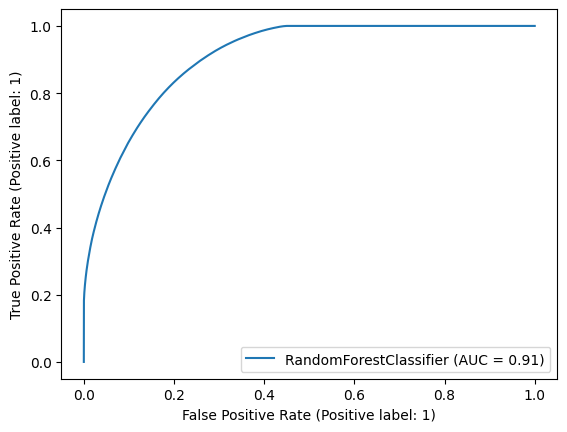

In [50]:
RocCurveDisplay.from_estimator(rfc,X_train,y_train)

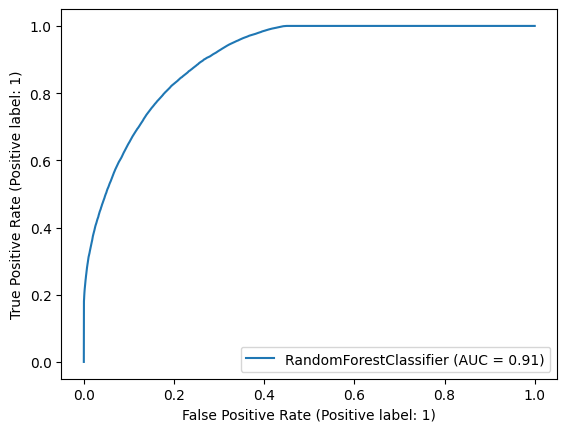

In [51]:
RocCurveDisplay.from_estimator(rfc,X_test,y_test)

We can be very satisfied as we were able to reduce the complexity of the dataset but without altering the results of the model. Now we just have to do the litmus test by verifying through a StratifiedKFold that the roc_auc remains constant for each fold.

In [52]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
print(cross_val_score(rfc, X, y, cv=stratified_kfold, scoring='roc_auc'))

[0.90617834 0.90618859 0.905626   0.90544003 0.90650763]


We see that for each fold the roc_auc is maintained at 0.90, so our model is stable in discriminating positive and negative classes

BONUS: INTERPRETING FORECASTS WITH LIME

LIME is a technique for explaining machine learning models whose main goal is to provide transparent and understandable interpretations regardless of the model used

In [53]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=['FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN',
                   'AMT_INCOME_TOTAL', 'DAYS_BIRTH' ,'DAYS_EMPLOYED','CNT_FAM_MEMBERS'],
    class_names=['Non Rilasciata', 'Rilasciata'],
    mode='classification'
)

In [56]:
idx_to_explain = 779
exp = explainer.explain_instance(X_test[idx_to_explain], rfc.predict_proba, num_features=6)

In [57]:
exp.show_in_notebook(show_table=True, show_all=True)

In this case for observation #779 in our test set we can see that the credit card was not issued and the reasons behind that decision.